In [1]:
import yfinance as yf

In [7]:
import datetime

end = datetime.datetime.now()
start = datetime.datetime(end.year - 20, end.month, end.day)
start

datetime.datetime(2004, 5, 1, 0, 0)

In [10]:
stock_name = "GOOG"
stock_data = yf.download(stock_name, start, end, progress=False)

stock_data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216
2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512


In [11]:
stock_data.shape

(4958, 6)

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

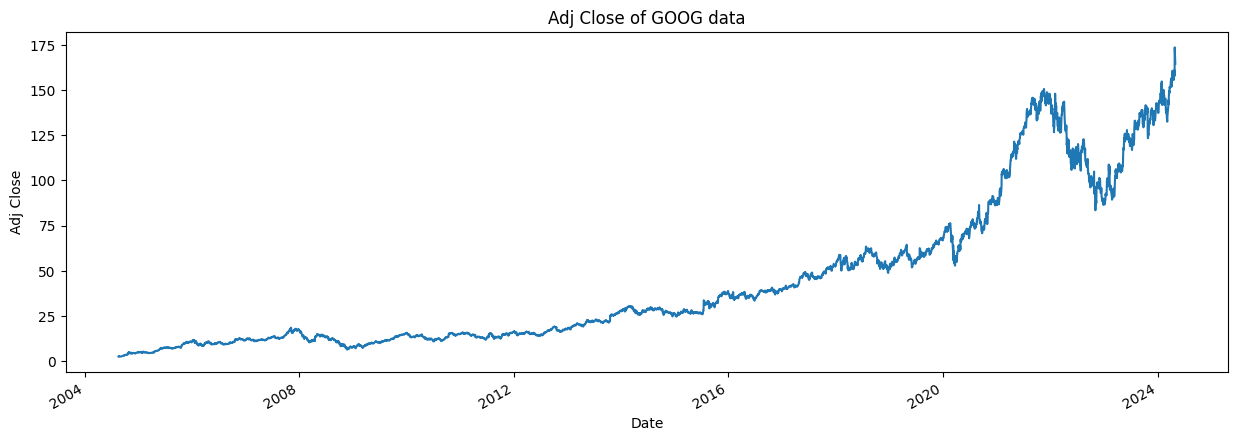

In [44]:
def plot_graph(figsize: tuple, values: pd.Series, stock_name: str, ylabel: str = None):
    """
    Plots the graph of the stock data
    """

    plt.figure(figsize=figsize)
    values.plot()
    plt.xlabel(values.index.name)
    if ylabel is None:
        plt.ylabel(values.name)
        plt.title(f"{values.name} of {stock_name} data")

    else:
        plt.ylabel(ylabel)
        plt.title(f"{ylabel} of {stock_name} data")

    return None


plot_graph(figsize=(15, 5), values=stock_data["Adj Close"], stock_name=stock_name)

In [38]:
# moving average for 250 days and 100 days

stock_data["MA_for_250_days"] = stock_data["Adj Close"].rolling(250).mean()
stock_data["MA_for_100_days"] = stock_data["Adj Close"].rolling(100).mean()

<Figure size 1500x500 with 0 Axes>

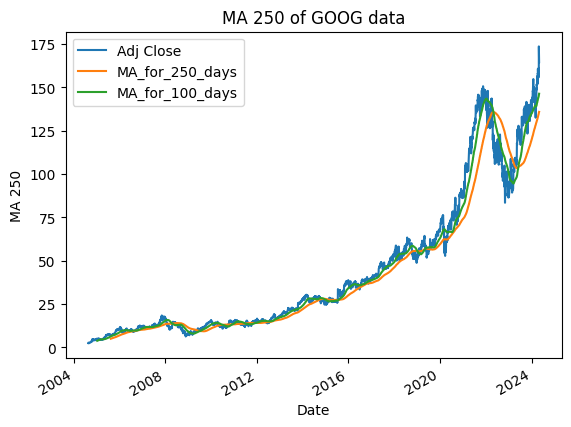

In [45]:
plot_graph(
    figsize=(15, 5),
    values=stock_data[["Adj Close", "MA_for_250_days", "MA_for_100_days"]],
    stock_name=stock_name,
    ylabel="MA 250",
)

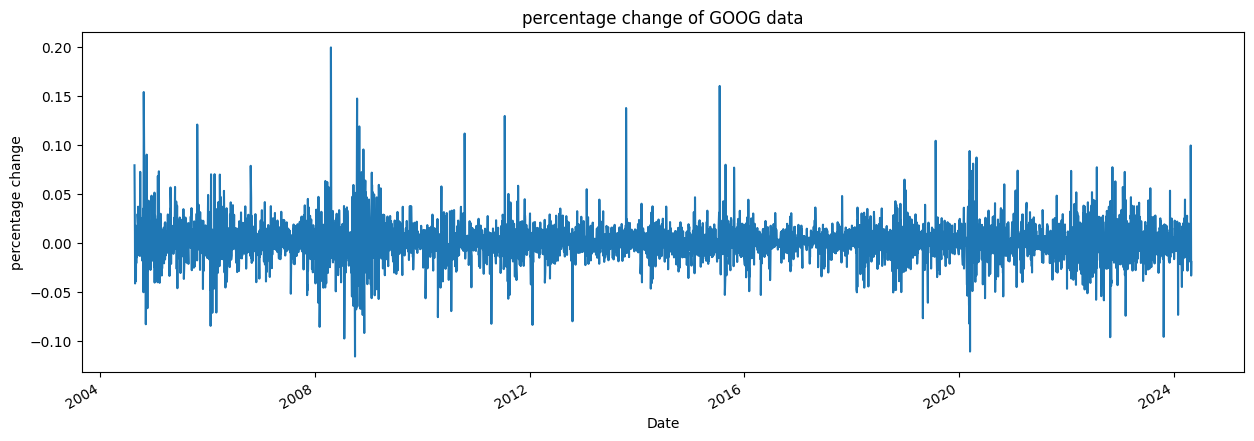

In [51]:
# percentage change
stock_data["percentage_change"] = stock_data["Adj Close"].pct_change()

plot_graph(
    figsize=(15, 5),
    values=stock_data["percentage_change"],
    stock_name=stock_name,
    ylabel="percentage change",
)

In [53]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data[["Adj Close"]])
scaled_data

array([[4.80154176e-05],
       [1.20751854e-03],
       [1.36609420e-03],
       ...,
       [1.00000000e+00],
       [9.66179677e-01],
       [9.47137552e-01]])

In [61]:
import numpy as np

x_data = []
y_data = []

for i in range(100, len(scaled_data)):
    x_data.append(scaled_data[i - 100 : i])
    y_data.append(scaled_data[i])

import numpy as np

x_data, y_data = np.array(x_data), np.array(y_data)

In [62]:
splitting_len = int(len(x_data) * 0.7)
x_train = x_data[:splitting_len]
y_train = y_data[:splitting_len]

x_test = x_data[splitting_len:]
y_test = y_data[splitting_len:]

In [63]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3400, 100, 1)
(3400, 1)
(1458, 100, 1)
(1458, 1)


In [64]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [65]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

d:\GitHub\GitHub\Project Ideas\stock_price_prediction\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [66]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [67]:
model.fit(x_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
3400/3400 ━━━━━━━━━━━━━━━━━━━━ 198s 56ms/step - loss: 2.6406e-04
Epoch 2/2
3400/3400 ━━━━━━━━━━━━━━━━━━━━ 178s 52ms/step - loss: 4.5649e-05


In [68]:
predictions = model.predict(x_test)
inv_predictions = scaler.inverse_transform(predictions)
inv_predictions

46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step


array([[ 58.26166 ],
       [ 58.438854],
       [ 58.783722],
       ...,
       [160.5762  ],
       [167.55603 ],
       [169.28786 ]], dtype=float32)

In [69]:
inv_y_test = scaler.inverse_transform(y_test)
inv_y_test

array([[ 59.19300079],
       [ 59.93999863],
       [ 59.79399872],
       ...,
       [173.69000244],
       [167.8999939 ],
       [164.63999939]])

In [70]:
ploting_data = pd.DataFrame(
    {"original_test_data": inv_y_test.reshape(-1), "predictions": inv_predictions.reshape(-1)},
    index=stock_data.index[splitting_len + 100 :],
)
ploting_data.head()

,original_test_data,predictions
Date,,
2018-07-16,59.193001,58.261662
2018-07-17,59.939999,58.438854
2018-07-18,59.793999,58.783722
2018-07-19,59.348000,58.930378
2018-07-20,59.245499,58.764671


<Figure size 1500x600 with 0 Axes>

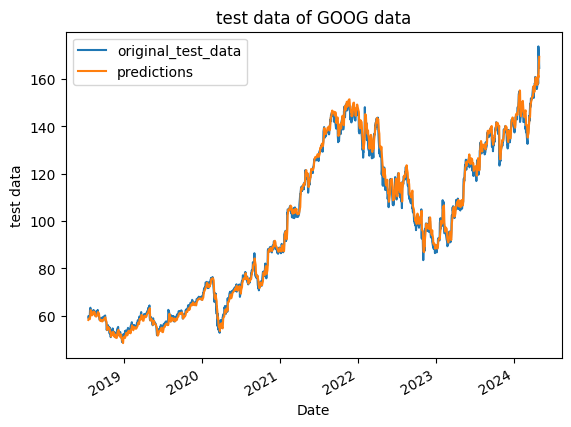

In [71]:
plot_graph((15, 6), ploting_data, stock_name, "test data")

In [72]:
model.save("Latest_stock_price_model.keras")